# Model Interpretability
We'll interpret our model's predictions using LIME (Local Interpretable Model-agnostic Explanations). LIME helps us understand which words in a review most strongly influence the model's classification decisions.
We start by copying the necessary code we need from the previous notebook so we can start interpreting using LIME.


In [5]:
import pandas as pd
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split


processed_path = "../data/processed/amazon_reviews_processed.csv"
df = pd.read_csv(processed_path)
df['label'] = df['polarity'].map({1: 0, 2: 1})
X = df['cleaned_review']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

best_model = load_model('../models/cnn/best_model.keras')
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

maxlen = 70  


Now we'll use LIME to analyze how the model makes its decisions and then visualize which words contribute most to positive/negative sentiment predictions.
We'll create a prediction function that:
1. Converts text to sequences using our tokenizer
2. Pads sequences to the required length
3. Gets predictions from our model
4. Returns probabilities for both negative and positive classes.

Finally, we'll display the models prediction, showing the original text, the top words that influenced the prediction, and list the contribution score for each word

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


<Figure size 1000x400 with 0 Axes>

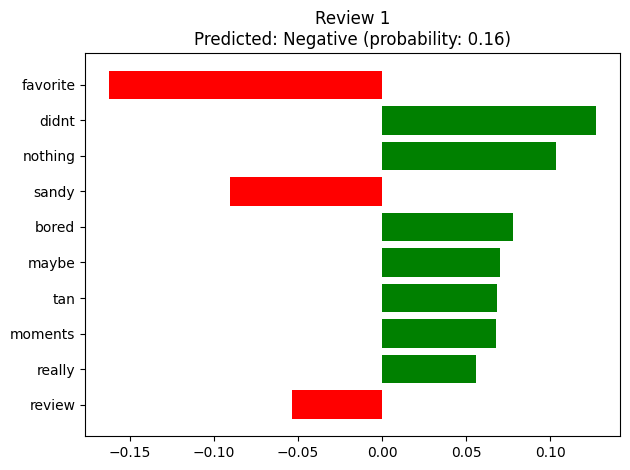


Review 1:
Text: book review tan sandy silence john macdonald one favorite travis mcgee novels although competently c...

Top contributing words:
favorite: -0.162
didnt: 0.127
nothing: 0.104
sandy: -0.090
bored: 0.078
maybe: 0.070
tan: 0.068
moments: 0.068
really: 0.056
review: -0.053


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


<Figure size 1000x400 with 0 Axes>

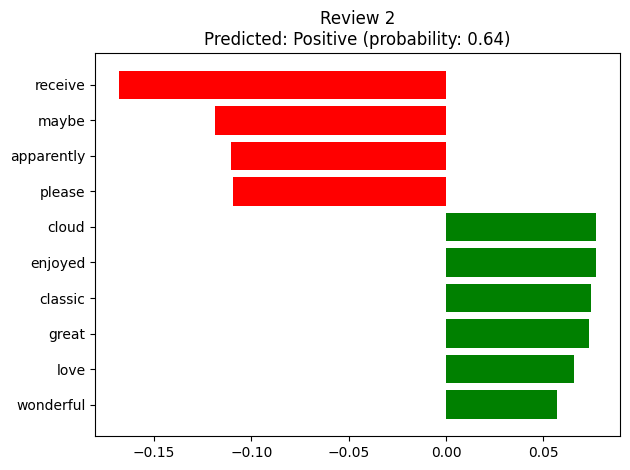


Review 2:
Text: sensational like traveling wilburys beatles touch elo love great production sixth beatle jeff lynne ...

Top contributing words:
receive: -0.168
maybe: -0.119
apparently: -0.110
please: -0.109
cloud: 0.077
enjoyed: 0.077
classic: 0.074
great: 0.074
love: 0.066
wonderful: 0.057


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


<Figure size 1000x400 with 0 Axes>

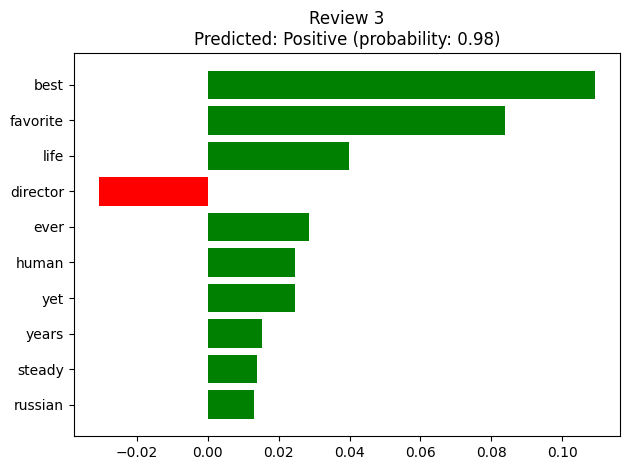


Review 3:
Text: favorite time one best films best stories humankinds place nature transcendence human affection ever...

Top contributing words:
best: 0.109
favorite: 0.084
life: 0.040
director: -0.031
ever: 0.029
human: 0.025
yet: 0.025
years: 0.015
steady: 0.014
russian: 0.013


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


<Figure size 1000x400 with 0 Axes>

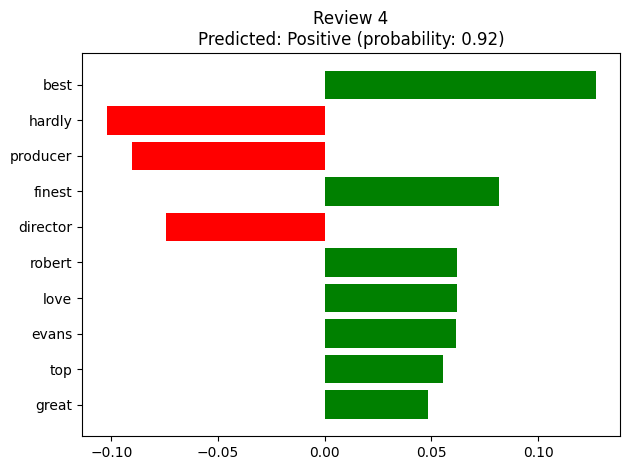


Review 4:
Text: one best movies time mystery wrapped enigmatic love story riddled corruption third century chinatown...

Top contributing words:
best: 0.127
hardly: -0.102
producer: -0.090
finest: 0.081
director: -0.074
robert: 0.062
love: 0.062
evans: 0.062
top: 0.055
great: 0.049


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


<Figure size 1000x400 with 0 Axes>

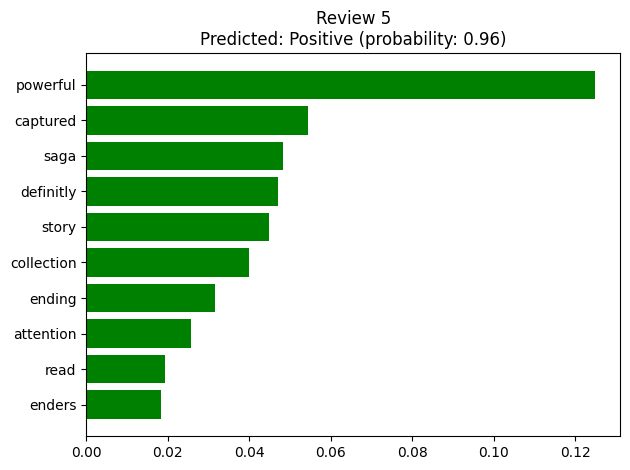


Review 5:
Text: marvoulous ending powerful saga powerful moving story card definitly captured attention series whole...

Top contributing words:
powerful: 0.125
captured: 0.054
saga: 0.048
definitly: 0.047
story: 0.045
collection: 0.040
ending: 0.032
attention: 0.026
read: 0.019
enders: 0.018




In [6]:
import numpy as np
from lime.lime_text import LimeTextExplainer
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences

#function to predict probabilities
def predict_prob(texts):
    sequences = tokenizer.texts_to_sequences(texts)
    padded = pad_sequences(sequences, maxlen=maxlen, padding='post')
    preds = best_model.predict(padded)
    return np.array([[1-p[0], p[0]] for p in preds])

#create LIME explainer and get sample texts
explainer = LimeTextExplainer(class_names=['Negative', 'Positive'])
num_examples = 5
sample_indices = np.random.choice(len(X_test), num_examples)
sample_texts = X_test.iloc[sample_indices].values

#nalyze each example
for idx, text in enumerate(sample_texts):
    exp = explainer.explain_instance(
        text, 
        predict_prob,
        num_features=10,
        top_labels=1
    )
    
    pred_probs = predict_prob([text])[0]
    pred_class = 'Positive' if pred_probs[1] > 0.5 else 'Negative'
    explained_label = exp.available_labels()[0]
    plt.figure(figsize=(10, 4))
    exp.as_pyplot_figure(label=explained_label)
    plt.title(f'Review {idx+1}\nPredicted: {pred_class} (probability: {pred_probs[1]:.2f})')
    plt.tight_layout()
    plt.show()
    
    print(f"\nReview {idx+1}:")
    print(f"Text: {text[:100]}...")
    print("\nTop contributing words:")
    for word, score in exp.as_list(label=explained_label):
        print(f"{word}: {score:.3f}")
    print("\n" + "="*50 + "\n")